In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [4]:
# Used for plot names
est = "fraud_adaboost"
scoreText = "F1-Score"

In [5]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [6]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


# Initial Parameter Grid Search

In [7]:
n_estimators = [1, 2, 5, 10, 25, 50, 100, 150, 250]
learning_rates = [0.1, 0.25, 0.5, 0.75]
paramGrid = {
#     'base_estimator': [DecisionTreeClassifier(criterion='entropy', random_state=randomSeed, max_depth=i), for i in [1, 4]],
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
}

nData = -1 # (all)
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(AdaBoostClassifier(random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True, scoring='f1')

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 5245 data samples
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.025320,0.001856,0.001002,0.000011,0.1,1,"{'learning_rate': 0.1, 'n_estimators': 1}",0.875000,0.860215,0.905263,...,0.881470,0.019240,30,0.892473,0.896552,0.885333,0.885942,0.888283,0.889717,0.004239
1,0.074401,0.049794,0.002992,0.003025,0.1,2,"{'learning_rate': 0.1, 'n_estimators': 2}",0.875000,0.860215,0.905263,...,0.881470,0.019240,30,0.892473,0.896000,0.885333,0.885942,0.888283,0.889606,0.004063
2,0.132446,0.004203,0.003391,0.000489,0.1,5,"{'learning_rate': 0.1, 'n_estimators': 5}",0.884211,0.860215,0.905263,...,0.896770,0.022198,28,0.909589,0.898936,0.902174,0.902703,0.906593,0.903999,0.003705
3,0.352655,0.017578,0.006183,0.000977,0.1,10,"{'learning_rate': 0.1, 'n_estimators': 10}",0.891304,0.923077,0.913043,...,0.910318,0.012488,17,0.917582,0.924731,0.918033,0.921409,0.915531,0.919457,0.003243
4,0.923331,0.015052,0.013165,0.000746,0.1,25,"{'learning_rate': 0.1, 'n_estimators': 25}",0.926316,0.923077,0.913043,...,0.919328,0.006065,10,0.917582,0.924731,0.926829,0.924324,0.918478,0.922389,0.003670
5,1.935137,0.065719,0.027128,0.001934,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.926316,0.924731,0.913043,...,0.924677,0.012150,3,0.932976,0.925532,0.930481,0.921833,0.932976,0.928760,0.004403
6,4.136846,0.139332,0.060240,0.009496,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.937500,0.924731,0.913043,...,0.926771,0.019531,1,0.938338,0.933687,0.930851,0.925532,0.938338,0.933349,0.004842
7,6.844301,0.052927,0.095544,0.017256,0.1,150,"{'learning_rate': 0.1, 'n_estimators': 150}",0.937500,0.926316,0.913043,...,0.925131,0.022307,2,0.938338,0.933333,0.936170,0.933333,0.944000,0.937035,0.003959
8,10.729713,0.398576,0.124267,0.011658,0.1,250,"{'learning_rate': 0.1, 'n_estimators': 250}",0.937500,0.916667,0.914894,...,0.923571,0.022383,5,0.952381,0.949602,0.941489,0.944000,0.944297,0.946354,0.004008
9,0.048271,0.005448,0.002393,0.000489,0.25,1,"{'learning_rate': 0.25, 'n_estimators': 1}",0.875000,0.860215,0.905263,...,0.881470,0.019240,30,0.892473,0.896552,0.885333,0.885942,0.888283,0.889717,0.004239


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26b01e62eb8>)

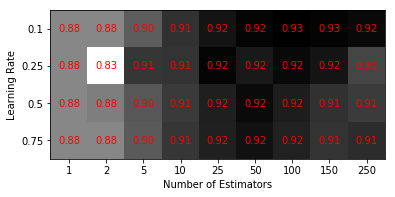

In [10]:
toPlot = np.zeros((len(learning_rates), len(n_estimators)))
for i, hls in enumerate(learning_rates):
    for j, a in enumerate(n_estimators):
        k = i * len(n_estimators) + j
        toPlot[i, j] = gs_results_df.loc[(gs_results_df.param_learning_rate == hls) & (gs_results_df.param_n_estimators == a)].mean_test_score
heatmap(toPlot, n_estimators, learning_rates, xlabel="Number of Estimators", ylabel="Learning Rate", savefig=est + pltNameSuffix + "_gs")

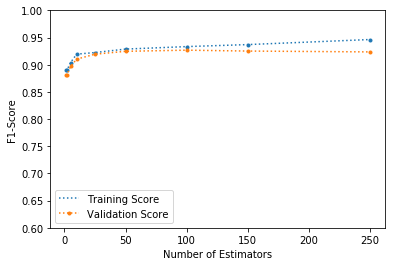

In [11]:
this_learning_rate = 0.1

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("Number of Estimators")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_lrslicep1")

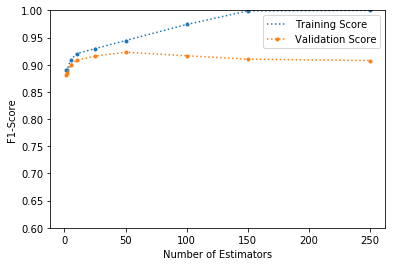

In [12]:
this_learning_rate = 0.50

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("Number of Estimators")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_lrslicep5")

In [13]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
yPred =  gs.best_estimator_.predict(X)
print(f'On the training data, we see precision and recall of:')
cr = classification_report(y, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)
print(f'but for the held-out test data we obtain just:')
yPred =  gs.best_estimator_.predict(XTest)
cr = classification_report(yTest, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)

From this, we choose the following parameters for computing the learning curve:
{'learning_rate': 0.1, 'n_estimators': 100}
On the training data, we see precision and recall of:
             precision    recall  f1-score   support

  Not Fraud       0.99      1.00      1.00      5000
      Fraud       0.98      0.89      0.93       246

avg / total       0.99      0.99      0.99      5246

but for the held-out test data we obtain just:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00    120000
      Fraud       0.65      0.77      0.70       246

avg / total       1.00      1.00      1.00    120246



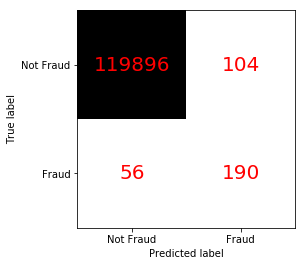

In [14]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

NOTE: UndefinedMetricWarnings may occur below in some cases with small data due to poor classification

In [15]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(AdaBoostClassifier(random_state=randomSeed, **lc_params), X, y, 
                          testSize = lcTestSize, scorer=f1_score, 
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                          randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'learning_rate': 0.1, 'n_estimators': 100}
Over 8 folds: [  31   67  146  316  500 1000 2000 3000]
Indices included at fold 0: 31
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 1: 67
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold 2: 146
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold 3: 316
	Model trained in 0.21s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.26s
Indices included at fold 4: 500
	Model trained in 0.26s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.30s
Indices

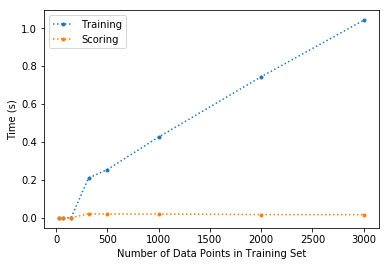

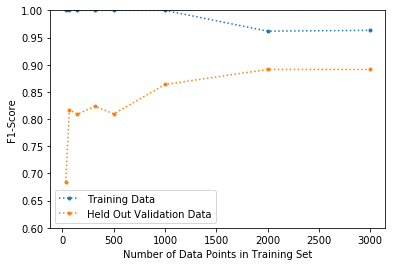

In [16]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, ylabel = scoreText, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [17]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.891 achieved with 2000 samples
